In [59]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import pydicom
import exifread

In [60]:
#age, race, sex, machine/manufacturer, smoking, pack-years, days to death/cancer, cancer, 

# Load Data
## PLCO

In [61]:
DATASET_PATH = '/Mounts/rbg-storage1/datasets/PLCO_XRAY/metadata_2022_03_05.json'
metadata = json.load(open(DATASET_PATH, 'r'))

In [62]:
RACE_ID_KEYS = {
    1: "White",
    2: "Black",
    3: "Hispanic",
    4: "Asian",
    6: "Pacific Islander",
    6: "American Indian",
    7: "Missing",
}

df = []
for p in metadata:
    pid = p['pid']
    
    pt_metadata = p['pt_metadata']
    
    gender = pt_metadata['sex']
    start_age = pt_metadata['bq_age']
    race = RACE_ID_KEYS.get(pt_metadata['race7'], 'Missing')
    is_smoker = pt_metadata['cig_stat']
    pack_years = pt_metadata['pack_years']
    
    lunc_cancer_diagnosis_days = pt_metadata['lung_cancer_diagdays']
    followup_days = pt_metadata['lung_exitdays']
    is_cancer = pt_metadata['lung_cancer']
    
    for e in p['accessions']:
        study_yr = e['study_yr']
        
        pid_int = int( str(ord(pid[0])) + ''.join(c for c in pid if c.isdigit()) )
        exam_int = int(f"{int(pid_int)}{int(study_yr)}")
        
        
        for s in e['image_series']:
            filename = s['filename']
            software = s['Image Software']
            w = s['Image ImageWidth']
            h = s['Image ImageLength']
            
            df.append({
                'pid': pid,
                'exam': exam_int,
                'filename': filename,
                'start_age': start_age,
                'gender': gender,
                'race': race,
                'is_smoker': is_smoker,
                'pack_years': pack_years,
                'is_cancer': is_cancer,
                'lung_cancer_diagnosis_days': lunc_cancer_diagnosis_days,
                'followup_days': followup_days,
                'study_yr': study_yr,
                'software': software,
                'width': w,
                'height': h
            })
        
df = pd.DataFrame(df)
df['dataset'] = 'PLCO'
df

,pid,exam,filename,start_age,gender,race,is_smoker,pack_years,is_cancer,lung_cancer_diagnosis_days,followup_days,study_yr,software,width,height,dataset
0,T-083431-8,8408343180,AI02934081407133557_v2.tif,67.0,2,White,2.0,30.0,0,-1.0,5224,0,RiverainMedicl,2095,2538,PLCO
1,T-083431-8,8408343182,AI02934081407133916_v2.tif,67.0,2,White,2.0,30.0,0,-1.0,5224,2,RiverainMedicl,2093,2537,PLCO
2,T-083431-8,8408343183,AI02934081407134032_v2.tif,67.0,2,White,2.0,30.0,0,-1.0,5224,3,RiverainMedicl,2089,2540,PLCO
3,T-083431-8,8408343181,AI02934081407133724_v2.tif,67.0,2,White,2.0,30.0,0,-1.0,5224,1,RiverainMedicl,2095,2538,PLCO
4,Y-086037-1,8908603712,AC01367021006152811_v2.tif,63.0,2,White,2.0,44.0,1,872.0,872,2,RiverainMedicl,2094,2541,PLCO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89711,T-032473-1,8403247310,AJ06916110206120921_v2.tif,68.0,1,White,2.0,24.0,0,-1.0,160,0,RiverainMedicl,2088,2542,PLCO
89712,U-005771-2,8500577120,AF0590773107100124_v2.tif,70.0,1,White,2.0,76.0,0,-1.0,2824,0,RiverainMedicl,2095,2543,PLCO
89713,N-085998-6,7808599860,AG06296080907113637_v2.tif,74.0,2,White,0.0,0.0,0,-1.0,349,0,RiverainMedicl,2093,2541,PLCO
89714,G-036878-9,7103687890,AC01397062306135648_v2.tif,72.0,2,White,0.0,0.0,0,-1.0,3542,0,RiverainMedicl,2094,2542,PLCO


# NLST X-Ray

In [14]:
DATASET_PATH = '/Mounts/rbg-storage1/datasets/ACRIN_XRAY/xray_dataset.json'
metadata = json.load(open(DATASET_PATH, 'r'))

In [15]:
RACE_ID_KEYS = {
    1: "White",
    2: "Black",
    3: "Asian",
    4: "American Indian",
    5: "Native Hawaiian",
    6: "Hispanic",
}

nlst_df = []
for p in tqdm(metadata):
    pid = p['pid']
    pt_metadata = p['pt_metadata']
    
    race = RACE_ID_KEYS.get(pt_metadata['race'][0], 'Missing')
    
    ethnicity = pt_metadata['ethnic'][0]
    gender = pt_metadata['gender'][0]
    start_age = pt_metadata['age'][0]
    pack_years = pt_metadata['pkyr'][0]
    is_smoker = pt_metadata['cigsmok'][0]
    is_cancer = pt_metadata['cancyr'][0] != -1
    followup_days = pt_metadata['fup_days'][0]
    lung_cancer_diagnosis_days = pt_metadata['candx_days'][0] # not sure
    
    for e in p['accessions']:
        screen_timepoint = e["screen_timepoint"]
        for s in e['image_series']: # seperate examno for each series???
            #study_yr = e['study_yr']
            series_id = s["series_id"]

            exam_int = int(f"{int(pid)}{int(screen_timepoint)}{int(series_id.split('.')[-1][-3:])}")
            
            dcm = pydicom.dcmread(s['path'], stop_before_pixels=True)
            
            manufacturer = dcm.Manufacturer
            if 'ManufacturerModelName' in dcm:
                model = dcm.ManufacturerModelName
            else:
                model = -1
            width = dcm.Columns
            height = dcm.Rows
            
            nlst_df.append({
                'pid': pid,
                'exam': exam_int,
                'series': series_id,
                'study_yr': screen_timepoint,
                    
                'start_age': start_age,
                'gender': gender,
                'race': race,
                'is_smoker': is_smoker,
                'pack_years': pack_years,
                'is_cancer': is_cancer,
                'lung_cancer_diagnosis_days': lunc_cancer_diagnosis_days,
                'followup_days': followup_days,
                'study_yr': study_yr,
                'manufacturer': manufacturer,
                'model': model,
                'width': width,
                'height': height
            })

nlst_df = pd.DataFrame(nlst_df)
nlst_df['dataset'] = 'nlst_acrin'
nlst_df

  1%|█▋                                                                                                                                                                   | 58/5491 [00:06<10:12,  8.87it/s]/Mounts/rbg-storage1/users/ludvig/miniforge3/envs/datascience/lib/python3.9/site-packages/pydicom/charset.py:732: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5491/5491 [19:00<00:00,  4.81it/s]


,pid,exam,series,study_yr,start_age,gender,race,is_smoker,pack_years,is_cancer,lung_cancer_diagnosis_days,followup_days,manufacturer,model,width,height,dataset
0,216290,2162902371,1.2.392.200036.9125.3.691189185206.64463256358...,2,57,2,White,0,30.0,False,-1.0,2413,"FUJI PHOTO FILM Co., ltd.",5501ES,1760,2140,nlst_acrin
1,216290,2162902370,1.2.392.200036.9125.3.691189185206.64463256358...,2,57,2,White,0,30.0,False,-1.0,2413,"FUJI PHOTO FILM Co., ltd.",5501ES,1760,2140,nlst_acrin
2,216290,2162900512,1.2.392.200036.9125.3.1.14482155.11317.512,2,57,2,White,0,30.0,False,-1.0,2413,"FUJI PHOTO FILM Co., ltd.",5501ES,1760,2140,nlst_acrin
3,216290,2162900512,1.2.392.200036.9125.3.1.14482155.11317.512,2,57,2,White,0,30.0,False,-1.0,2413,"FUJI PHOTO FILM Co., ltd.",5501ES,1760,2140,nlst_acrin
4,216290,2162901512,1.2.392.200036.9125.3.1.15332690.11317.512,2,57,2,White,0,30.0,False,-1.0,2413,"FUJI PHOTO FILM Co., ltd.",5501ES,1760,2140,nlst_acrin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19856,205665,20566513,1.2.840.113619.2.67.2164109270.279204100511311...,2,61,1,White,0,80.0,False,-1.0,2333,GE MEDICAL SYSTEMS,ADS_1.0,2022,1736,nlst_acrin
19857,205665,20566513,1.2.840.113619.2.67.2164109270.279204100511311...,2,61,1,White,0,80.0,False,-1.0,2333,GE MEDICAL SYSTEMS,ADS_1.0,1750,1946,nlst_acrin
19858,205665,20566513,1.2.840.113619.2.67.2164109270.279204100511311...,2,61,1,White,0,80.0,False,-1.0,2333,GE MEDICAL SYSTEMS,ADS_1.0,2022,1736,nlst_acrin
19859,204562,20456201,1.2.840.113619.2.67.2164156847.227870312301056...,2,59,1,White,1,120.0,True,-1.0,128,GE MEDICAL SYSTEMS,Revolution XQi ADS_19.16.1,2022,2022,nlst_acrin


## Combine

In [39]:
combined_df = pd.concat((df,nlst_df), axis=0)
series_df = combined_df[[
    'dataset',
    'pid',
    'exam',
    'series',
    'study_yr',
    'manufacturer',
    'model',
    'software',
    'width',
    'height'
]]
patient_df = combined_df.groupby('pid').first().reset_index()[[
    'dataset',
    'pid',
    'start_age',
    'gender',
    'race',
    'is_smoker',
    'pack_years',
    'is_cancer',
    'followup_days',
    'lung_cancer_diagnosis_days'
]]

# Stats

In [52]:
len(patient_df.loc[patient_df.dataset == 'nlst_acrin'])

5491

In [53]:
len(patient_df.loc[patient_df.dataset == 'PLCO'])

25000

In [54]:
len(series_df.loc[series_df.dataset == 'nlst_acrin'])

19861

In [55]:
len(series_df.loc[series_df.dataset == 'PLCO'])

89716

In [40]:
Counter(patient_df.loc[patient_df.dataset == 'nlst_acrin'].is_cancer)

Counter({0: 5267, 1: 224})

In [41]:
Counter(patient_df.loc[patient_df.dataset == 'PLCO'].is_cancer)

Counter({0: 24008, 1: 992})

(array([2.000e+00, 4.185e+03, 4.147e+03, 3.288e+03, 4.296e+03, 3.603e+03,
        2.063e+03, 2.349e+03, 1.066e+03, 1.000e+00]),
 array([51. , 53.7, 56.4, 59.1, 61.8, 64.5, 67.2, 69.9, 72.6, 75.3, 78. ]),
 <BarContainer object of 10 artists>)

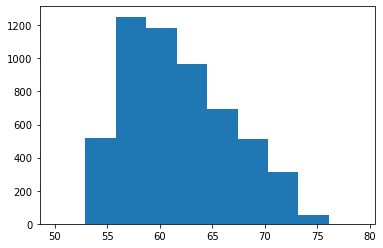

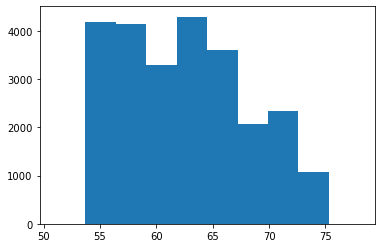

In [42]:
# start age
plt.hist(patient_df.loc[patient_df.dataset == 'nlst_acrin'].start_age)
plt.figure()
plt.hist(patient_df.loc[patient_df.dataset == 'PLCO'].start_age)

In [56]:
# gender
print( Counter(patient_df.loc[patient_df.dataset == 'nlst_acrin'].gender) )
Counter(patient_df.loc[patient_df.dataset == 'PLCO'].gender)

Counter({1: 3034, 2: 2457})


Counter({1: 12946, 2: 12054})

In [63]:
# race
print( Counter(patient_df.loc[patient_df.dataset == 'nlst_acrin'].race) )
Counter(patient_df.loc[patient_df.dataset == 'PLCO'].race)

Counter({'White': 5151, 'Black': 222, 'Asian': 39, 'Hispanic': 36, 'Missing': 25, 'American Indian': 17, 'Native Hawaiian': 1})


Counter({'Black': 1601,
         'White': 21670,
         'Hispanic': 428,
         'Asian': 1085,
         'Missing': 156,
         'American Indian': 60})

In [57]:
# is smoker
print( Counter(patient_df.loc[patient_df.dataset == 'nlst_acrin'].is_smoker) )
Counter(patient_df.loc[patient_df.dataset == 'PLCO'].is_smoker)

Counter({0.0: 2770, 1.0: 2721})


Counter({0.0: 10724, 2.0: 11328, 1.0: 2948})

(array([1.6923e+04, 4.2740e+03, 2.1330e+03, 7.9400e+02, 3.3900e+02,
        1.5400e+02, 5.3000e+01, 2.0000e+01, 7.0000e+00, 1.0000e+00]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

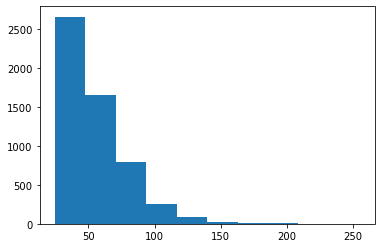

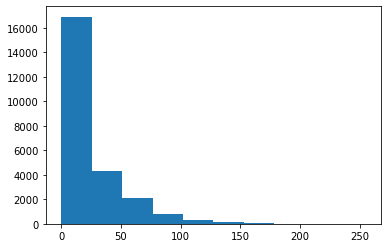

In [45]:
# pack_years
plt.hist(patient_df.loc[(patient_df.dataset == 'nlst_acrin') & (patient_df.pack_years != -1)].pack_years)
plt.figure()
plt.hist(patient_df.loc[(patient_df.dataset == 'PLCO') & (patient_df.pack_years != -1)].pack_years)

In [46]:
# X-ray machines
Counter(series_df.loc[series_df.dataset == 'PLCO'].software)

Counter({'RiverainMedicl': 87371, 'VIDAR Demoscan': 2345})

In [47]:
Counter(series_df.loc[series_df.dataset == 'nlst_acrin'].manufacturer)

Counter({'FUJI PHOTO FILM Co., ltd.': 5977,
         'SIEMENS': 2100,
         'Philips Medical Systems': 1295,
         'GE MEDICAL SYSTEMS': 5647,
         'DeJarnette Research Systems': 478,
         'Agfa-Gevaert AG': 1418,
         'AGFA': 1261,
         'Fuji Photo Film Co.,Ltd.': 700,
         '"GE Healthcare"': 66,
         'Fuji Photo Film Co.,Ltd. and GE Medical Systems': 660,
         'Agfa': 137,
         'FUJI': 43,
         'KODAK': 72,
         'HOLOGIC, Inc.': 2,
         'Siemens Health Services': 5})

Text(0.5, 1.0, 'PLCO image sizes')

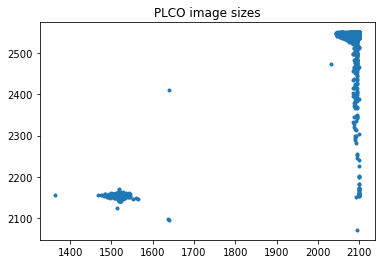

In [48]:
df = series_df.loc[series_df.dataset == 'PLCO']
plt.scatter(df.width, df.height, marker='.')
plt.title("PLCO image sizes")

Text(0.5, 1.0, 'NLST-Xray image sizes')

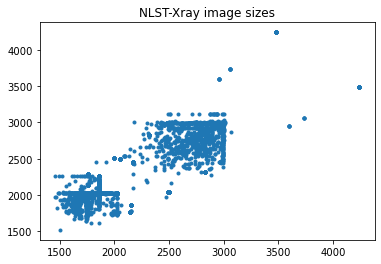

In [58]:
df = series_df.loc[series_df.dataset == 'nlst_acrin']
plt.scatter(df.width, df.height, marker='.')
plt.title("NLST-Xray image sizes")